# DTW로 동향이 유사한 그래프 찾기

In [5]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

In [6]:
df = pd.read_csv('../extract/dcinside/result/dcinside_avante.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Title'] = df['Title'].fillna('')
df['Body'] = df['Body'].fillna('')
df['Comment'] = df['Comment'].fillna('')
df.head()

,Date,Time,Title,Body,Comment,View,Like,Community,CarName
0,2019-01-01,00:59,아반떼 페리 되고 나서,\nA8이 이뻐 보임...,,146.0,0.0,dcinside,아반떼
1,2019-01-01,03:38,시발 취업되면 아반떼라도 사고 싶다,중고 모닝쟝을 1년 더 타야 하는대,타던 모닝 나에게 팔지 않을래?\n아반떼 hd 200만원 ㄱㄱ 못생긴거 빼면 단점이...,141.0,0.0,dcinside,아반떼
2,2019-01-01,09:00,새해에는 모닝에서 벗어나고싶다,아반떼 타고시퍼,조촐하네\n모닝타다가 아반떼타면 신세계지,105.0,0.0,dcinside,아반떼
3,2019-01-01,10:44,본인 182에 105키로 눈마주치면 바로눈깜,병신찐따새끼들 걍약약강 존나많음 ㅋㅋ\n차도 좆병신같은거 타는새끼들이 특히많음\n모...,역시 짱용차를 타는사람은 다르군여\n닉갑ㄴ,116.0,0.0,dcinside,아반떼
4,2019-01-01,11:24,차고민좀 들어주세요,좆닝타는데\n이번에 돈좀생겨서 아반떼로 갈랫더니\n스마트 풀옵이 케파랑 돈 400차...,지랄말고 케파 가자!!\n할부할거면 걍 중형타던가 아니면 아방스 가시던지\n다 일시...,161.0,0.0,dcinside,아반떼


## Kiwi 토크나이저
DC인사이드 아이오닉에 대해 28초 소요

In [7]:
kiwi = Kiwi()
stopwords = Stopwords()

# 사용자 단어 추가
USER_WORD = [
    '현대자동차', '기아', '현차', '현대차', '현기', '현대', '', '', 
    '아이오닉', '제네시스', '아반떼', '니로', '벤츠', '토레스', '쏘나타', '카니발', '하이브리드', '모닝', '봉고', '테슬라', '포르쉐', '레이', '쏘렌토', '르노', '렉서스', 
]
for word in USER_WORD:
    kiwi.add_user_word(word, 'NNP')  # 고유명사로 추가

# 불용어 리스트 생성 및 추가
USER_STOP_WORD = [
    # '현대자동차', '기아', '현차', '현대차', '모델', '전기차', '자동차', '중고', '차', '현기', '내연', '운전', '현대', '차종', '신차', '국산', '전기', '', '', 
    # '아이오닉', '제네시스', '아반떼', '니로', '벤츠', '토레스', '쏘나타', '카니발', '하이브리드', '모닝', '봉고', '테슬라', '포르쉐', '레이', '쏘렌토', '르노', '렉서스', 

    # '차이', '돈', '밥', '이유', '글', '집', '세대', '고민', '내년', '올해', '비교', '개', '값', '닉', '급', '생각', '뒤', '기준', '현재', '사람', '애', '카',
    # '회사', '키', '코', '가능', '시작', '오늘', '사진', '봄', '차량', '정도', '기본', '탐', '일반', '브랜드', '막', '나라', '택', '풀',
    # '앞', '뒤', '추천', '말', '맘',  '땅', '주변', '추가', '신', '최고', '기사', '길', '순서', '도로', '초반', '기차', '미래', '배', '세계', '일', '자체',
    # '테', '독', '상실', '만약', '필요', '베', '느낌', '렌', '랜', '지금', '이번', '노인', '페리', '형', '다시', '렁', '듬', '져', '인', '전', '쌈', '때', '트', '감상', 
    # '따리', '뉴', '점', '특유', '동안', '엔', '칸', '특징', '인생', '정보', '예정', '롱', '주', '다음', '시속', '르', '뉘', '쉐', '츄', '쌍', '줄', '혼', '', '', '', '', 
    # '좆', '병신', '시발', '지랄', '새끼', '색', '존나', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 
]
for stop_word in USER_STOP_WORD:
    stopwords.add((stop_word, 'NNG'))
    
# 명사 추출 함수
def get_nouns_kiwi(sentence):
    tokens = kiwi.tokenize(sentence, stopwords=stopwords, normalize_coda=True)
    # 명사(NNG, NNP), 동사(VV), 형용사(VA)
    filtered_tokens = [token.form for token in tokens if token.tag in {'NNG', 'NNP'}]
    return filtered_tokens

In [8]:
tokenizer = get_nouns_kiwi

# 게시글 제목과 내용을 합친 후 명사 추출
TITLE_WEIGHT = 5
BODY_WEIGHT = 2
COMMENT_WEIGHT = 0
df['nouns_title'] = df['Title'].apply(tokenizer)
df['nouns_body'] = df['Body'].apply(tokenizer)
df['nouns_comment'] = df['Comment'].apply(tokenizer)
df['nouns'] = TITLE_WEIGHT * df['nouns_title'] + BODY_WEIGHT * df['nouns_body'] + COMMENT_WEIGHT * df['nouns_comment']
df[['Date', 'Title', 'Body', 'nouns']].head()

,Date,Title,Body,nouns
0,2019-01-01,아반떼 페리 되고 나서,\nA8이 이뻐 보임...,"[아반떼, 페리, 아반떼, 페리, 아반떼, 페리, 아반떼, 페리, 아반떼, 페리]"
1,2019-01-01,시발 취업되면 아반떼라도 사고 싶다,중고 모닝쟝을 1년 더 타야 하는대,"[시발, 취업, 아반떼, 시발, 취업, 아반떼, 시발, 취업, 아반떼, 시발, 취업..."
2,2019-01-01,새해에는 모닝에서 벗어나고싶다,아반떼 타고시퍼,"[새해, 모닝, 새해, 모닝, 새해, 모닝, 새해, 모닝, 새해, 모닝, 아반떼, ..."
3,2019-01-01,본인 182에 105키로 눈마주치면 바로눈깜,병신찐따새끼들 걍약약강 존나많음 ㅋㅋ\n차도 좆병신같은거 타는새끼들이 특히많음\n모...,"[본인, 눈, 눈, 본인, 눈, 눈, 본인, 눈, 눈, 본인, 눈, 눈, 본인, 눈..."
4,2019-01-01,차고민좀 들어주세요,좆닝타는데\n이번에 돈좀생겨서 아반떼로 갈랫더니\n스마트 풀옵이 케파랑 돈 400차...,"[차, 고민, 차, 고민, 차, 고민, 차, 고민, 차, 고민, 좆닝, 이번, 돈,..."


In [9]:
# # 날짜별 단어 등장 및 게시글 개수 계산
grouped = df.groupby('Date').agg(nouns=('nouns', 'sum'), post_count=('Date', 'size'))
word_count_by_date = grouped['nouns'].apply(lambda x: dict(Counter(x)))
wc_df = pd.DataFrame({'Date': grouped.index, 'Word_Count': word_count_by_date, 'Post_Count': grouped['post_count']}, )
wc_df.head()

,Date,Word_Count,Post_Count
Date,,,
2019-01-01,2019-01-01,"{'아반떼': 42, '페리': 5, '시발': 5, '취업': 5, '중고': 1...",11
2019-01-02,2019-01-02,"{'학식': 7, '시절': 5, '현실': 5, '감각': 5, '아반떼': 68...",17
2019-01-03,2019-01-03,"{'학식': 5, '차': 18, '유지비': 12, '민주': 5, '경차': 2...",17
2019-01-04,2019-01-04,"{'돌이': 5, '차': 44, '엑센트': 7, '아반떼': 87, '예상': ...",26
2019-01-05,2019-01-05,"{'아반떼': 79, '작년': 4, '골드': 2, '인수': 4, '엔진': 2...",19


In [10]:
BASE_WORD = '차'
COMP_WORD = '전기'
TODAY = '2023-10-15'
BASE_PERIOD = 365
COMP_PERIOD = 10
ROLLING_DAYS_BASE = 10
ROLLING_DAYS_COMP = 3

today = pd.to_datetime(TODAY)

# base_df: 기준 단어의 데이터
base_start_date = today - pd.Timedelta(days=BASE_PERIOD)
base_df = wc_df[(base_start_date < wc_df['Date']) & (wc_df['Date'] <= today)][['Date', 'Word_Count']]
base_df['Word_Count'] = base_df['Word_Count'].map(lambda x: x.get(BASE_WORD, 0))
base_df[f'{ROLLING_DAYS_BASE}_day_avg'] = base_df['Word_Count'].rolling(window=ROLLING_DAYS_BASE, min_periods=1).mean()

# comp_df: 비교 단어의 데이터
comp_start_date = today - pd.Timedelta(days=COMP_PERIOD)
comp_df = wc_df[(comp_start_date < wc_df['Date']) & (wc_df['Date'] <= today)][['Date', 'Word_Count']]
comp_df['Word_Count'] = comp_df['Word_Count'].map(lambda x: x.get(COMP_WORD, 0))
comp_df[f'{ROLLING_DAYS_COMP}_day_avg'] = comp_df['Word_Count'].rolling(window=ROLLING_DAYS_COMP, min_periods=1).mean()

# 각 시계열을 7일 이동 평균으로 변환
base_df[f'{ROLLING_DAYS_BASE}_day_avg'] = base_df['Word_Count'].rolling(window=ROLLING_DAYS_BASE, min_periods=1).mean()
comp_df[f'{ROLLING_DAYS_COMP}_day_avg'] = comp_df['Word_Count'].rolling(window=ROLLING_DAYS_COMP, min_periods=1).mean()

# 변환된 시계열 데이터
base_series = base_df[f'{ROLLING_DAYS_BASE}_day_avg'].values.reshape(-1,1)
comp_series = comp_df[f'{ROLLING_DAYS_COMP}_day_avg'].values.reshape(-1, 1)
# comp_series = comp_df['Word_Count'].values.reshape(-1, 1)

In [11]:
# 최적 유사성 찾기
min_distance = float('inf')
best_start_index = 0
comp_series_normalized_best = None

# 10일 윈도우로 비교
for start in range(len(base_series) - len(comp_series) + 1):
    candidate_series = base_series[start:start+10]

    # comp_series를 candidate_series의 최대/최소값에 맞춰 정규화
    comp_series_normalized = (comp_series - np.min(comp_series)) / (np.max(comp_series) - np.min(comp_series))
    comp_series_normalized = comp_series_normalized * (np.max(candidate_series) - np.min(candidate_series)) + np.min(candidate_series)

    # 정규화된 comp_series와 candidate_series의 DTW 거리 계산
    distance, path = fastdtw(candidate_series, comp_series, dist=euclidean)
    
    if distance < min_distance:
        min_distance = distance
        best_start_index = start
        comp_series_normalized_best = comp_series_normalized

print(f"가장 유사한 부분은 index {best_start_index}에서 시작해 index {best_start_index+10}에서 끝납니다. DTW 거리는 {min_distance}입니다.")


가장 유사한 부분은 index 75에서 시작해 index 85에서 끝납니다. DTW 거리는 427.0입니다.


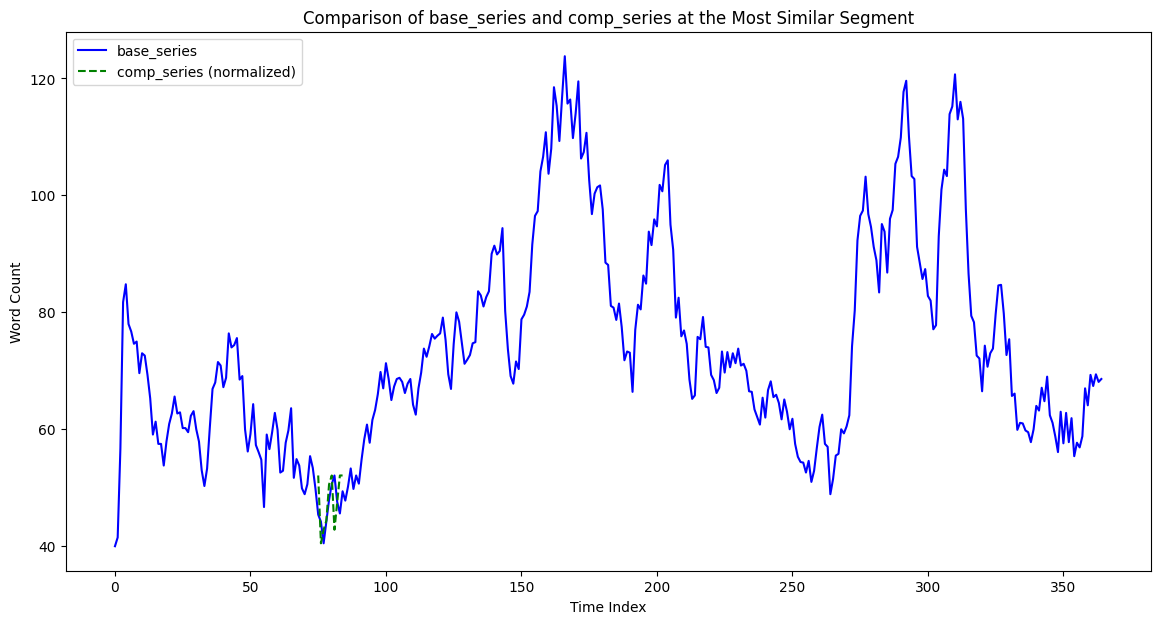

In [12]:
# 전체 base_series 시각화
plt.figure(figsize=(14, 7))
plt.plot(range(len(base_series)), base_series, label='base_series', color='blue')

# comp_series를 base_series에서 가장 유사한 위치에 시각화
# plt.plot(range(best_start_index, best_start_index+len(comp_series)), comp_series, label='comp_series', color='red', linestyle='--')
# comp_series_normalized_best 시각화 (정규화된 데이터)
plt.plot(range(best_start_index, best_start_index+len(comp_series)), comp_series_normalized_best, label='comp_series (normalized)', color='green', linestyle='--')

# 그래프 레이블 및 타이틀 추가
plt.xlabel('Time Index')
plt.ylabel('Word Count')
plt.title('Comparison of base_series and comp_series at the Most Similar Segment')
plt.legend()
plt.show()